In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import seaborn as sns
from matplotlib import rcParams

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/collect_mi_results.csv')
df.replace('celltype.l3', 'Cell type MI', inplace=True)
df.replace('protein_counts', 'Protein MI', inplace=True)
df.replace('clone', 'Clonal MI', inplace=True)
df.replace('author_day', 'Temporal MI', inplace=True)
df.replace('ng_idx', 'Spatial MI', inplace=True)
df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

In [3]:
def cell_number_scaling(x, N0, s, I_inf):
    """
    Cell number scaling function: I(x) = max(I_0, I_inf - (x / N0) ** (-s))
    """
    I_0 = 0
    with np.errstate(divide="ignore", invalid="ignore", over="ignore"):
        # Calculate the scaling term more safely to avoid overflow
        ratio = x / N0
        # Use log-space calculation to avoid overflow
        scaling_term = np.where(
            ratio > 0,
            np.exp(-s * np.log(ratio)),
            0.0
        )
        result = np.where(x > 0, np.maximum(I_0, I_inf - scaling_term), np.nan)
    return result

In [20]:
df = df[df['quality'] == 1]
df = df[df['signal']!= 'Cell type MI']
df

,dataset,size,quality,algorithm,signal,seed,mi_value,umis_per_cell
177,PBMC,100,1.0,Geneformer,Protein MI,42,1.71489,8100
178,PBMC,100,1.0,Geneformer,Protein MI,2701,2.14159,8100
181,PBMC,100,1.0,PCA,Protein MI,42,3.66277,8100
182,PBMC,100,1.0,PCA,Protein MI,2701,3.64559,8100
185,PBMC,100,1.0,Rand. Proj.,Protein MI,42,2.81897,8100
...,...,...,...,...,...,...,...,...
4839,shendure,10000000,1.0,PCA,Temporal MI,42,1.14821,2500
4840,shendure,10000000,1.0,PCA,Temporal MI,1404,1.09550,2500
4841,shendure,10000000,1.0,Rand. Proj.,Temporal MI,42,0.62163,2500
4842,shendure,10000000,1.0,Rand. Proj.,Temporal MI,1404,0.62163,2500


Protein MI
[[Model]]
    Model(cell_number_scaling)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8000
    # data points      = 10
    # variables        = 3
    chi-square         = 0.50557577
    reduced chi-square = 0.07222511
    Akaike info crit   = -23.8464245
    Bayesian info crit = -22.9386692
    R-squared          = 0.91577780
##  Warning: uncertainties could not be estimated:
[[Variables]]
    N0:     1.7674e+68 (init = 100)
    s:      0.01919625 (init = 0.5)
    I_inf:  21.2465440 (init = 4.748335)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Clonal MI
[[Model]]
    Model(cell_number_scaling)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data po

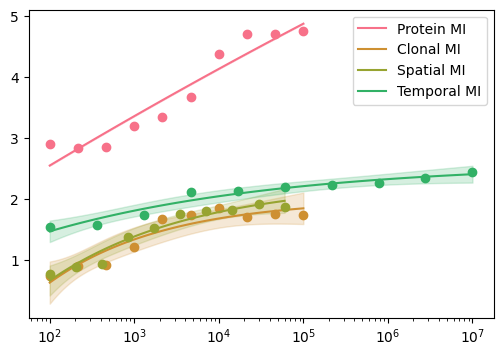

In [31]:
fig, axs = plt.subplots(figsize=(6, 4))
for i, signal in enumerate(df['signal'].unique()):
    subset = df[df['algorithm']== 'SCVI']
    subset = subset[subset['signal'] == signal]
    subset = subset.groupby(['size']).mean(numeric_only=True).reset_index()

    x_data = subset['size'].values
    y_data = subset['mi_value'].values

    model = Model(cell_number_scaling)
    params = model.make_params(N0=100, s=0.5, I_inf=max(y_data))
    result = model.fit(y_data, params, x=x_data)
    print(signal)
    print(result.fit_report())
    print()

    # plot with confidence bands
    x_fit = np.logspace(np.log10(min(x_data)), np.log10(max(x_data)), 100)
    y_fit = result.eval(params=result.params, x=x_fit)

    pretty_palette = sns.color_palette("husl", 8)
    axs.plot(x_data, y_data, 'o', color=pretty_palette[i])
    axs.plot(x_fit, y_fit, '-', color=pretty_palette[i], label=signal)

    y_upper = result.eval_uncertainty(params=result.params,
                                        x=x_fit, sigma=2)
    print(y_upper)
    y_lower = -y_upper
    if y_upper.max() < 2:
        axs.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower,
                        color=pretty_palette[i], alpha=0.2)
plt.xscale('log')
plt.legend()